In [1]:
using Plots
using ParticleFilters
using Distributions
using StaticArrays
using LinearAlgebra
using Random
using StatsBase
#using Reel
using SparseArrays
using GridInterpolations
using DataStructures
using DataFrames
using CSV
using Distributed

In [2]:

include("atan2.jl")
include("obs_rel.jl")
include("polargrid_rel_qual.jl")
rng = MersenneTwister(2);
#

In [3]:
# random walk

POS_0 = [6.0, 60.0]
CRS_0 = 90 # target's course
SPD_0 = 1 # 1 or 2
TGT_SPD = 1

#input is course in degrees and rng
#returns next course in degrees
function next_crs(crs,rng)
    if rand(rng) < .9
        return crs
    end
    crs = (crs + rand(rng,[-1,1])*30) % 360
    if crs < 0 crs += 360 end
    return crs
end

# state as tuple (x, y, crs, spd) of target (spd of o/s)
function f(state, control, rng)
    r, θ, crs, spd = state
    θ += control[1]
    spd = control[2]
    if θ < 0 θ += 360 end
    θ = θ % 360
    crs -= control[1]
    if crs < 0 crs += 360 end
    crs = crs % 360
    x = r*cos(π/180*θ)
    y = r*sin(π/180*θ)
    pos = [x + TGT_SPD*cos(π/180*crs) - spd, y + 
        TGT_SPD*sin(π/180*crs)]
    crs = next_crs(crs,rng)
    r = sqrt(pos[1]^2 + pos[2]^2)
    θ = atan2(pos[1],pos[2])*180/π
    if θ < 0 θ += 360 end
    return (r, θ, crs, spd)::NTuple{4, Real}
end
#

f (generic function with 1 method)

In [4]:
function r(s)
    range = s[1]
    if range > 150 return -.1 end  # reward to not lose track of contact
    if range <= 10 return -1 end  # collision avoidance
    return .1  # being in "sweet spot" maximizes reward
end
#

r (generic function with 1 method)

In [5]:
#angles = [0, 30, 60, 90, 120, 150, 210, 240, 270, 300, 330]

statespace = thestates
actionspace = ((30,1), (0,1), (-30,1), (30, 2), (0,2), (-30,2))

action_index(a) = trunc(Int, 2*(a[1]/30+1) + a[2])
actions_ = ((-30,1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))



((-30, 1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))

In [6]:
# returns vector rather than Tuple, for particle filter
function f2(x, u, rng)
    temp = [i for i in f(x, u, rng)]
    return temp
end

f2 (generic function with 1 method)

In [7]:
totals = [0.0]
θ = zeros(length(grid),6);
e = sparse(zeros(length(grid),6))
#θ = [r(Tuple(ind2x(grid, j))) for j in 1:length(grid), i in 1:6];

In [12]:

N = 500
model = ParticleFilterModel{Vector{Float64}}(f2, g)
pfilter = SIRParticleFilter(model, N);
α = 0.5
γ = 0.98
ϵ = 0.15
x = [20, 60, 90, 1, 1];
λ = 0.95
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
counter = 0


0

In [ ]:
## Q-learning loop
#plots = []
#betas = Deque{Array}()
#β = zeros(length(grid),6);

epochs = 5000
epochsize = 500

total = 0
rando = 0

last = 0
x = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, 1, 1];     
b = ParticleCollection([x[1:4] for i in 1:N]);     
ξ = sparse(weighted_grid_2(b)/N)
uu = next_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], ϵ, rng)
u = uu[1]
rando += uu[2]

for i in 1:(epochsize*epochs)
    counter += 1
    
    e[:,u] += ξ
    last = transpose(θ[:,u])*ξ
    
    # choose next action
    uu = next_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], ϵ, rng)
    u = uu[1]
    rando += uu[2]
    a_star = uu[3]
    
    #observe new state and reward
    xp = f2(x, actions_[u], rng)
    y = h(xp, rng)
    b = update(pfilter, b, actions_[u], y)
    rew = r(Tuple(xp))
       
    ξ = sparse(weighted_grid_2(b)/N)
     
    total += rew
        
    #cur = (rew + γ * max2([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], rng))
    
    #argmax state-action pair, not realized state-action pair?
    cur = transpose(θ[:,a_star])*ξ
    
    δ = rew + γ * cur - last
    
    θ += α * δ * e
    #if uu[2] == 0
    e *= γ * λ
    #else
    #    e = sparse(zeros(length(grid),6))
    #end
    
        
    if counter % epochsize == 0
        push!(totals, total*500/epochsize)
        println("--------- CURRENT: ", round(total*500/epochsize, sigdigits=4), " AVG: ", round(mean(totals), sigdigits=4), " Epoch: ", 
            trunc(Int, counter/epochsize), " -----------")
        total = 0
        rando = 0
        xp = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, rand(rng, [1,2]), 1];
        b = ParticleCollection([xp[1:4] for i in 1:N]);
        ξ = sparse(weighted_grid_2(b)/N)
    end
    if counter % (epochsize*5) == 0
        thetaframe = DataFrame(θ)
        CSV.write("current4_2.csv", thetaframe)
    end
    
    x = xp
    
    
    #plotting
    #r_ = [row[1] for row in particles(b)]
    #theta = [row[2] for row in particles(b)]*π/180
    #x_theta = x[2]*π/180
    #x_r = x[1 ]
    
    #print(".")
    #plt = plot(proj=:polar, lims=(0,200), size=(1000,1000))
    #scatter!(theta, r_, markersize=1, label="particles")
    #scatter!([x_theta], [x_r], markersize=3, label="target")
          
    #push!(plots, plt)
    
end


--------- CURRENT: -3.2 AVG: 8.877 Epoch: 8808 -----------
--------- CURRENT: -20.8 AVG: 8.874 Epoch: 8809 -----------
--------- CURRENT: -5.8 AVG: 8.873 Epoch: 8810 -----------
--------- CURRENT: -29.2 AVG: 8.869 Epoch: 8811 -----------
--------- CURRENT: 9.7 AVG: 8.869 Epoch: 8812 -----------
--------- CURRENT: -9.8 AVG: 8.868 Epoch: 8813 -----------
--------- CURRENT: 23.6 AVG: 8.869 Epoch: 8814 -----------
--------- CURRENT: -26.1 AVG: 8.866 Epoch: 8815 -----------
--------- CURRENT: -26.0 AVG: 8.863 Epoch: 8816 -----------
--------- CURRENT: -31.4 AVG: 8.859 Epoch: 8817 -----------
--------- CURRENT: -28.4 AVG: 8.856 Epoch: 8818 -----------
--------- CURRENT: -18.8 AVG: 8.853 Epoch: 8819 -----------
--------- CURRENT: -32.4 AVG: 8.849 Epoch: 8820 -----------
--------- CURRENT: -38.8 AVG: 8.845 Epoch: 8821 -----------
--------- CURRENT: 5.4 AVG: 8.845 Epoch: 8822 -----------
--------- CURRENT: -12.0 AVG: 8.843 Epoch: 8823 -----------
--------- CURRENT: -15.3 AVG: 8.841 Epoch: 8824 

--------- CURRENT: 34.1 AVG: 8.648 Epoch: 9085 -----------
--------- CURRENT: -39.4 AVG: 8.644 Epoch: 9086 -----------
--------- CURRENT: 46.4 AVG: 8.647 Epoch: 9087 -----------
--------- CURRENT: 29.1 AVG: 8.649 Epoch: 9088 -----------
--------- CURRENT: 6.3 AVG: 8.649 Epoch: 9089 -----------
--------- CURRENT: 20.4 AVG: 8.65 Epoch: 9090 -----------
--------- CURRENT: 10.7 AVG: 8.65 Epoch: 9091 -----------
--------- CURRENT: 23.8 AVG: 8.652 Epoch: 9092 -----------
--------- CURRENT: 8.7 AVG: 8.652 Epoch: 9093 -----------
--------- CURRENT: -5.6 AVG: 8.65 Epoch: 9094 -----------
--------- CURRENT: -20.4 AVG: 8.648 Epoch: 9095 -----------
--------- CURRENT: 22.0 AVG: 8.649 Epoch: 9096 -----------
--------- CURRENT: 50.0 AVG: 8.653 Epoch: 9097 -----------
--------- CURRENT: -29.4 AVG: 8.649 Epoch: 9098 -----------
--------- CURRENT: -16.0 AVG: 8.647 Epoch: 9099 -----------
--------- CURRENT: -20.8 AVG: 8.644 Epoch: 9100 -----------
--------- CURRENT: 32.4 AVG: 8.647 Epoch: 9101 ---------

--------- CURRENT: -36.6 AVG: 8.508 Epoch: 9224 -----------
--------- CURRENT: -36.8 AVG: 8.504 Epoch: 9225 -----------
--------- CURRENT: -5.4 AVG: 8.503 Epoch: 9226 -----------
--------- CURRENT: -25.5 AVG: 8.5 Epoch: 9227 -----------
--------- CURRENT: 3.6 AVG: 8.499 Epoch: 9228 -----------
--------- CURRENT: -48.4 AVG: 8.494 Epoch: 9229 -----------
--------- CURRENT: -10.0 AVG: 8.493 Epoch: 9230 -----------
--------- CURRENT: -14.0 AVG: 8.491 Epoch: 9231 -----------
--------- CURRENT: -22.0 AVG: 8.488 Epoch: 9232 -----------
--------- CURRENT: -32.6 AVG: 8.485 Epoch: 9233 -----------
--------- CURRENT: -15.8 AVG: 8.482 Epoch: 9234 -----------
--------- CURRENT: -3.8 AVG: 8.481 Epoch: 9235 -----------
--------- CURRENT: -42.6 AVG: 8.477 Epoch: 9236 -----------
--------- CURRENT: -10.2 AVG: 8.475 Epoch: 9237 -----------
--------- CURRENT: 49.4 AVG: 8.479 Epoch: 9238 -----------
--------- CURRENT: -20.8 AVG: 8.476 Epoch: 9239 -----------
--------- CURRENT: 27.2 AVG: 8.478 Epoch: 9240 

--------- CURRENT: -38.4 AVG: 8.227 Epoch: 9362 -----------
--------- CURRENT: 31.6 AVG: 8.229 Epoch: 9363 -----------
--------- CURRENT: -19.5 AVG: 8.226 Epoch: 9364 -----------
--------- CURRENT: 11.5 AVG: 8.226 Epoch: 9365 -----------
--------- CURRENT: -31.2 AVG: 8.223 Epoch: 9366 -----------
--------- CURRENT: -35.2 AVG: 8.219 Epoch: 9367 -----------
--------- CURRENT: -35.2 AVG: 8.216 Epoch: 9368 -----------
--------- CURRENT: -34.6 AVG: 8.212 Epoch: 9369 -----------
--------- CURRENT: 18.8 AVG: 8.213 Epoch: 9370 -----------
--------- CURRENT: 36.0 AVG: 8.215 Epoch: 9371 -----------
--------- CURRENT: -27.0 AVG: 8.212 Epoch: 9372 -----------
--------- CURRENT: 46.2 AVG: 8.215 Epoch: 9373 -----------
--------- CURRENT: -17.6 AVG: 8.213 Epoch: 9374 -----------
--------- CURRENT: 16.2 AVG: 8.214 Epoch: 9375 -----------
--------- CURRENT: -29.8 AVG: 8.211 Epoch: 9376 -----------
--------- CURRENT: -0.4 AVG: 8.21 Epoch: 9377 -----------
--------- CURRENT: -29.0 AVG: 8.207 Epoch: 9378 

--------- CURRENT: 28.8 AVG: 8.016 Epoch: 9500 -----------
--------- CURRENT: -14.9 AVG: 8.014 Epoch: 9501 -----------
--------- CURRENT: -23.0 AVG: 8.011 Epoch: 9502 -----------
--------- CURRENT: -26.6 AVG: 8.008 Epoch: 9503 -----------
--------- CURRENT: -27.4 AVG: 8.005 Epoch: 9504 -----------
--------- CURRENT: -26.6 AVG: 8.002 Epoch: 9505 -----------
--------- CURRENT: -41.4 AVG: 7.998 Epoch: 9506 -----------
--------- CURRENT: 35.2 AVG: 8.0 Epoch: 9507 -----------
--------- CURRENT: -14.0 AVG: 7.998 Epoch: 9508 -----------
--------- CURRENT: 15.0 AVG: 7.999 Epoch: 9509 -----------
--------- CURRENT: 18.1 AVG: 8.0 Epoch: 9510 -----------
--------- CURRENT: 10.8 AVG: 8.0 Epoch: 9511 -----------
--------- CURRENT: -39.8 AVG: 7.996 Epoch: 9512 -----------
--------- CURRENT: -6.384e-16 AVG: 7.995 Epoch: 9513 -----------
--------- CURRENT: -9.8 AVG: 7.994 Epoch: 9514 -----------
--------- CURRENT: -7.0 AVG: 7.992 Epoch: 9515 -----------
--------- CURRENT: -23.2 AVG: 7.99 Epoch: 9516 -

--------- CURRENT: -26.2 AVG: 7.768 Epoch: 9638 -----------
--------- CURRENT: -46.2 AVG: 7.763 Epoch: 9639 -----------
--------- CURRENT: 43.4 AVG: 7.766 Epoch: 9640 -----------
--------- CURRENT: 11.6 AVG: 7.766 Epoch: 9641 -----------
--------- CURRENT: 28.9 AVG: 7.768 Epoch: 9642 -----------
--------- CURRENT: -16.6 AVG: 7.766 Epoch: 9643 -----------
--------- CURRENT: -28.2 AVG: 7.763 Epoch: 9644 -----------
--------- CURRENT: -33.8 AVG: 7.76 Epoch: 9645 -----------
--------- CURRENT: -37.4 AVG: 7.756 Epoch: 9646 -----------
--------- CURRENT: -46.2 AVG: 7.751 Epoch: 9647 -----------
--------- CURRENT: -3.6 AVG: 7.75 Epoch: 9648 -----------
--------- CURRENT: -34.8 AVG: 7.747 Epoch: 9649 -----------
--------- CURRENT: 41.2 AVG: 7.749 Epoch: 9650 -----------
--------- CURRENT: 15.4 AVG: 7.75 Epoch: 9651 -----------
--------- CURRENT: -18.6 AVG: 7.748 Epoch: 9652 -----------
--------- CURRENT: -27.6 AVG: 7.745 Epoch: 9653 -----------
--------- CURRENT: -19.2 AVG: 7.743 Epoch: 9654 -

--------- CURRENT: 10.6 AVG: 7.547 Epoch: 9776 -----------
--------- CURRENT: -47.0 AVG: 7.542 Epoch: 9777 -----------
--------- CURRENT: -22.2 AVG: 7.54 Epoch: 9778 -----------
--------- CURRENT: -1.6 AVG: 7.539 Epoch: 9779 -----------
--------- CURRENT: -21.6 AVG: 7.537 Epoch: 9780 -----------
--------- CURRENT: 17.8 AVG: 7.538 Epoch: 9781 -----------
--------- CURRENT: -4.8 AVG: 7.536 Epoch: 9782 -----------
--------- CURRENT: -47.2 AVG: 7.532 Epoch: 9783 -----------
--------- CURRENT: -33.8 AVG: 7.528 Epoch: 9784 -----------
--------- CURRENT: -21.2 AVG: 7.526 Epoch: 9785 -----------
--------- CURRENT: -16.4 AVG: 7.524 Epoch: 9786 -----------
--------- CURRENT: -19.4 AVG: 7.522 Epoch: 9787 -----------
--------- CURRENT: 42.4 AVG: 7.525 Epoch: 9788 -----------
--------- CURRENT: -41.0 AVG: 7.521 Epoch: 9789 -----------
--------- CURRENT: -22.7 AVG: 7.518 Epoch: 9790 -----------
--------- CURRENT: 42.3 AVG: 7.521 Epoch: 9791 -----------
--------- CURRENT: -22.0 AVG: 7.519 Epoch: 9792

--------- CURRENT: -9.8 AVG: 7.263 Epoch: 9914 -----------
--------- CURRENT: 19.8 AVG: 7.264 Epoch: 9915 -----------
--------- CURRENT: -22.2 AVG: 7.262 Epoch: 9916 -----------
--------- CURRENT: 9.2 AVG: 7.262 Epoch: 9917 -----------
--------- CURRENT: 46.8 AVG: 7.265 Epoch: 9918 -----------
--------- CURRENT: -36.8 AVG: 7.261 Epoch: 9919 -----------
--------- CURRENT: -43.6 AVG: 7.257 Epoch: 9920 -----------
--------- CURRENT: -5.0 AVG: 7.256 Epoch: 9921 -----------
--------- CURRENT: -35.2 AVG: 7.253 Epoch: 9922 -----------
--------- CURRENT: 40.1 AVG: 7.255 Epoch: 9923 -----------
--------- CURRENT: -24.2 AVG: 7.253 Epoch: 9924 -----------
--------- CURRENT: -29.0 AVG: 7.25 Epoch: 9925 -----------
--------- CURRENT: -28.2 AVG: 7.247 Epoch: 9926 -----------
--------- CURRENT: 25.2 AVG: 7.248 Epoch: 9927 -----------
--------- CURRENT: -12.8 AVG: 7.247 Epoch: 9928 -----------
--------- CURRENT: -28.6 AVG: 7.244 Epoch: 9929 -----------
--------- CURRENT: -39.4 AVG: 7.24 Epoch: 9930 --

--------- CURRENT: -22.6 AVG: 6.773 Epoch: 10306 -----------
--------- CURRENT: 5.0 AVG: 6.773 Epoch: 10307 -----------
--------- CURRENT: -12.6 AVG: 6.771 Epoch: 10308 -----------
--------- CURRENT: -32.8 AVG: 6.768 Epoch: 10309 -----------
--------- CURRENT: 34.6 AVG: 6.77 Epoch: 10310 -----------
--------- CURRENT: -48.6 AVG: 6.766 Epoch: 10311 -----------
--------- CURRENT: 12.0 AVG: 6.766 Epoch: 10312 -----------
--------- CURRENT: 4.4 AVG: 6.766 Epoch: 10313 -----------
--------- CURRENT: 11.0 AVG: 6.766 Epoch: 10314 -----------
--------- CURRENT: -28.2 AVG: 6.763 Epoch: 10315 -----------
--------- CURRENT: -24.0 AVG: 6.761 Epoch: 10316 -----------
--------- CURRENT: 15.4 AVG: 6.762 Epoch: 10317 -----------
--------- CURRENT: 38.2 AVG: 6.764 Epoch: 10318 -----------
--------- CURRENT: -23.8 AVG: 6.762 Epoch: 10319 -----------
--------- CURRENT: 12.0 AVG: 6.762 Epoch: 10320 -----------
--------- CURRENT: -5.2 AVG: 6.761 Epoch: 10321 -----------
--------- CURRENT: -43.0 AVG: 6.757 

In [24]:
transpose(θ[:,2])*ξ

0.0015269765963268022

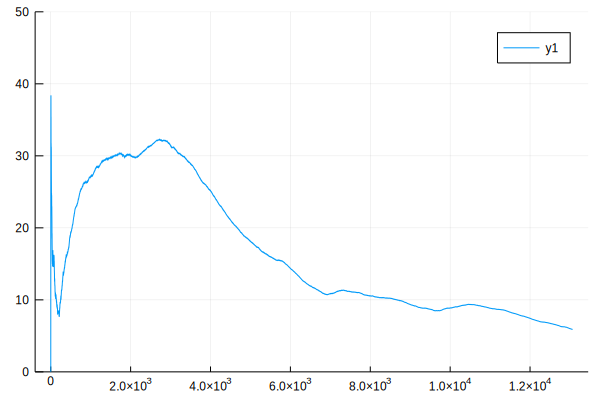

In [27]:
xx = []
yy = []
yyy = []
for (i, t) in enumerate(totals)
    push!(xx, i)
    push!(yy, t)
    push!(yyy, mean(yy))
end

plot(xx, yyy, ylims = (0,50))

2.0131182926706272e35

In [11]:
thetaframe = DataFrame(θ)
CSV.write("0.44_theta_12.1_1.csv", thetaframe)

"0.44_theta_12.1_1.csv"

In [51]:
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
ξ = weighted_grid_2(b)/N
var(ξ)


3.5612535612535624e-5